# Notebook 6: Integrating Macroeconomic and Market Data for Yield Curve Movement Prediction — ML Approach  
# Author: Will Wu

---

## **Table of Contents** ##

1. [Introduction](#1)
2. [Load and Setup](#2)
3. [Data Preparation](#3)
    - [Target Variable Defition](#3a)
    - [Data Cleaning](#3b)
4. [Advanced Feature Engineering](#4)
    - [Lagged Values](#4a)
    - [Momentum - rolling mean](#4b)
    - [Term Structure](#4c)
    - [Drop missing values](#4d)
5. [Data Preparation](#5)
    - [Train Test Split](#5a)
    - [Scaling](#5b)
6. [Model Training: First Round](#6)
    - [Regression Models](#6a)
    - [Random Forest Model](#6b)
    - [XGBoost](#6c)
7. [Regime Splitting](#7)
    - [Regime Review](#7a)
    - [Splitting Data into Regime-Specific Subsets](#7b)
8. [Train the Linear Regression on the five regimes](#8)
    - [Model Training](#8a)
    - [Model Performance Interpretation & Insights](#8b)
    - [LR with L1 regularization](#8c)
    - [Model Performance Interpretation & Insights](#8d)
9. [Train the Linear Regression on the five regimes](#9)
    - [Model Training](#9a)
    - [Model Performance Interpretation & Insights](#9b)
    - [Retrain Random Forest with Feature Selection](#9c)
    - [Model Performance Interpretation & Insights](#9d)
10. [Summary and Next Steps](#10)
    


---

## 1. Introduction <a class="anchor" id="1"></a>

This notebook focuses on leveraging macroeconomic and market data—previously downloaded and prepared—to build machine learning models aimed at predicting future yield curve changes. The process began with thorough data cleaning and preparation, including the creation of target variables that reflect yield movements over specific horizons. 

Through advanced feature engineering, multiple iterations of model training, evaluation, and tuning were performed. The goal is to develop robust predictive models capable of capturing the complex dynamics of the yield curve and providing reliable forecasts of future yield changes. This workflow combines data-driven modeling with domain-specific insights to enhance our understanding and prediction accuracy of treasury yield curve movements.

---

## 2. Loading and Setup <a class="anchor" id="2"></a>

In [1]:
# Import the necessary packages for this notebook
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


- Load Dataset

In [2]:
# Import the yield changes dataset
yield_changes_df = pd.read_csv("../data/yield_changes_from_3_month.csv", index_col=0)

# Convert index to datetime
yield_changes_df.index = pd.to_datetime(yield_changes_df.index)

# Check head()
yield_changes_df.head(3)

3_month  6_month  1_year  2_year  3_year  5_year  7_year  10_year  \
2019-01-03    -0.01    -0.04   -0.10   -0.11   -0.12   -0.12   -0.12    -0.10   
2019-01-04     0.01     0.04    0.07    0.11    0.12    0.12    0.12     0.11   
2019-01-07     0.03     0.03    0.01    0.03    0.04    0.04    0.04     0.03   

            20_year  30_year  
2019-01-03    -0.08    -0.05  
2019-01-04     0.08     0.06  
2019-01-07     0.03     0.01

In [3]:
# Import the yield dataset
yield_curve = pd.read_csv("../data/yield_cleaned.csv", index_col=0)

# Convert index to datetime
yield_curve.index = pd.to_datetime(yield_curve.index)

# To match the yield changes dataset, we need to remove the first line and 1_month column
yield_df = yield_curve.iloc[1:, 1:].copy()

# Check head
yield_df.head(3)

3_month  6_month  1_year  2_year  3_year  5_year  7_year  10_year  \
2019-01-03     2.41     2.47    2.50    2.39    2.35    2.37    2.44     2.56   
2019-01-04     2.42     2.51    2.57    2.50    2.47    2.49    2.56     2.67   
2019-01-07     2.45     2.54    2.58    2.53    2.51    2.53    2.60     2.70   

            20_year  30_year  
2019-01-03     2.75     2.92  
2019-01-04     2.83     2.98  
2019-01-07     2.86     2.99

In [4]:
# Import the macro and market data dataset
macro_df = pd.read_csv("../data/macro_data.csv", index_col=0)

# Convert index to datetime
macro_df.index = pd.to_datetime(macro_df.index)

# Check head
macro_df.head(3)

CPI  CPI_yoy_change    PPI  PPI_yoy_change     PCE  \
2019-01-03  252.594        2.147329  202.3        3.266973  102.63   
2019-01-04  252.594        2.147329  202.3        3.266973  102.63   
2019-01-07  252.594        2.147329  202.3        3.266973  102.63   

            PCE_yoy_change  Unemployment Rate  Unemployment_mom_change  \
2019-01-03        1.941892                3.8                 0.000000   
2019-01-04        1.941892                3.9                 2.631579   
2019-01-07        1.941892                3.9                 2.631579   

            Unemployment_yoy_change       GDP  ...  GDP_yoy_change  \
2019-01-03                -9.523810  20798.73  ...         5.61701   
2019-01-04                -4.878049  20798.73  ...         5.61701   
2019-01-07                -4.878049  20798.73  ...         5.61701   

            Fed_Fund_Rate_Lower  Fed_Fund_Rate_Lower_Upper  rate_change_bps  \
2019-01-03                 2.25                        2.5             25.0   
2019-01-04                 2.25                        2.5             25.0   
2019-01-07                 2.25                        2.5             25.0   

            SP500_Close  SP500_daily_return  VIX_Close  VIX_daily_change  \
2019-01-03  2447.889893           -2.475673  25.450001          9.603796   
2019-01-04  2531.939941            3.433571  21.379999        -15.992147   
2019-01-07  2549.689941            0.701043  21.400000          0.093548   

            Dollar_Index  Dollar_Index_return  
2019-01-03      115.4611            -0.264755  
2019-01-04      114.9813            -0.415551  
2019-01-07      114.5621            -0.364581  

[3 rows x 21 columns]

In [5]:
# Combine yield_df and macro_df
agg_df = pd.concat([yield_df, macro_df], axis=1)

# check the head
agg_df.head()

3_month  6_month  1_year  2_year  3_year  5_year  7_year  10_year  \
2019-01-03     2.41     2.47    2.50    2.39    2.35    2.37    2.44     2.56   
2019-01-04     2.42     2.51    2.57    2.50    2.47    2.49    2.56     2.67   
2019-01-07     2.45     2.54    2.58    2.53    2.51    2.53    2.60     2.70   
2019-01-08     2.46     2.54    2.60    2.58    2.57    2.58    2.63     2.73   
2019-01-09     2.45     2.52    2.59    2.56    2.54    2.57    2.64     2.74   

            20_year  30_year  ...  GDP_yoy_change  Fed_Fund_Rate_Lower  \
2019-01-03     2.75     2.92  ...         5.61701                 2.25   
2019-01-04     2.83     2.98  ...         5.61701                 2.25   
2019-01-07     2.86     2.99  ...         5.61701                 2.25   
2019-01-08     2.88     3.00  ...         5.61701                 2.25   
2019-01-09     2.90     3.03  ...         5.61701                 2.25   

            Fed_Fund_Rate_Lower_Upper  rate_change_bps  SP500_Close  \
2019-01-03                        2.5             25.0  2447.889893   
2019-01-04                        2.5             25.0  2531.939941   
2019-01-07                        2.5             25.0  2549.689941   
2019-01-08                        2.5             25.0  2574.409912   
2019-01-09                        2.5             25.0  2584.959961   

            SP500_daily_return  VIX_Close  VIX_daily_change  Dollar_Index  \
2019-01-03           -2.475673  25.450001          9.603796      115.4611   
2019-01-04            3.433571  21.379999        -15.992147      114.9813   
2019-01-07            0.701043  21.400000          0.093548      114.5621   
2019-01-08            0.969529  20.469999         -4.345796      114.7272   
2019-01-09            0.409805  19.980000         -2.393746      114.1394   

            Dollar_Index_return  
2019-01-03            -0.264755  
2019-01-04            -0.415551  
2019-01-07            -0.364581  
2019-01-08             0.144114  
2019-01-09            -0.512346  

[5 rows x 31 columns]

In [6]:
# Check shape
agg_df.shape

(1702, 31)

---

## 3. Data Preparation <a class="anchor" id="3"></a>

### 3.1 Target Variable Defition <a class="anchor" id="3a"></a>

As mentioned in the previous notebook, the overall goal of this project is to understand and predict future yield curve changes. In this notebook, we focus on forecasting the changes over a 6-month horizon (approximately 90 trading days). Specifically, for each term, the target variable is defined as:

$$Y_{t, \text{term}} = \text{Yield}{\text{term}, t+90} - \text{Yield}{\text{term}, t}$$

This difference captures the change in yield for a given term over 90 days. Variations across different terms reflect non-parallel shifts (steepening, flattening, twists), while synchronized changes across terms indicate parallel shifts. 

Example:
If today’s date is ( t ), and the 10-year yield is 4.0%, and after 90 trading days it is 4.5%, then:

$$
Y_{t, \text{10Y}} = 4.5\% - 4.0\% = +0.5\% = 50 bps
$$
where 1% = 100bps (In fixed-income, we usually use bps in stead of % as the unit of yield changes)
<br>This target variable quantifies the expected change in the yield for each term over the next 90 days.


In [7]:
# Define forecast horizon: 90 days
forecast_horizon = 90

# Extract the yield column names
yield_columns = yield_df.columns

for term_col in yield_columns:
    # loop through each term of yield
    # Shift the t+90 yield values back to row t
    future_yield = agg_df[term_col].shift(-1 * forecast_horizon)

    # Calculate the target variable: Yt+90 - Yt
    # Times 100 to get unit in bps
    agg_df[f'target_{term_col}_{forecast_horizon}D_change'] = (future_yield - agg_df[term_col]) * 100

In [8]:
# Sanity Check 
agg_df.iloc[[0, 90, 180], :][['3_month', '6_month', '1_year', '2_year', '3_year', '5_year', '7_year',
       '10_year', '20_year', '30_year','target_3_month_90D_change',
       'target_6_month_90D_change', 'target_1_year_90D_change',
       'target_2_year_90D_change', 'target_3_year_90D_change',
       'target_5_year_90D_change', 'target_7_year_90D_change',
       'target_10_year_90D_change', 'target_20_year_90D_change',
       'target_30_year_90D_change']]

3_month  6_month  1_year  2_year  3_year  5_year  7_year  10_year  \
2019-01-03     2.41     2.47    2.50    2.39    2.35    2.37    2.44     2.56   
2019-05-14     2.41     2.43    2.32    2.20    2.17    2.20    2.30     2.42   
2019-09-20     1.91     1.91    1.84    1.69    1.63    1.61    1.68     1.74   

            20_year  30_year  target_3_month_90D_change  \
2019-01-03     2.75     2.92                        0.0   
2019-05-14     2.67     2.86                      -50.0   
2019-09-20     1.99     2.17                      -34.0   

            target_6_month_90D_change  target_1_year_90D_change  \
2019-01-03                       -4.0                     -18.0   
2019-05-14                      -52.0                     -48.0   
2019-09-20                      -35.0                     -38.0   

            target_2_year_90D_change  target_3_year_90D_change  \
2019-01-03                     -19.0                     -18.0   
2019-05-14                     -51.0                     -54.0   
2019-09-20                     -33.0                     -29.0   

            target_5_year_90D_change  target_7_year_90D_change  \
2019-01-03                     -17.0                     -14.0   
2019-05-14                     -59.0                     -62.0   
2019-09-20                     -26.0                     -23.0   

            target_10_year_90D_change  target_20_year_90D_change  \
2019-01-03                      -14.0                       -8.0   
2019-05-14                      -68.0                      -68.0   
2019-09-20                      -20.0                      -15.0   

            target_30_year_90D_change  
2019-01-03                       -6.0  
2019-05-14                      -69.0  
2019-09-20                      -16.0

In [9]:
# For the last 90 row of data, we will have no target variable, so I will drop them right now
# Identify all target columns
target_cols = [col for col in agg_df.columns if col.startswith('target')]

# 2. Drop rows where ANY of the target variables are missing (which will be the last 90 rows)
# It's safest to drop NaNs across all target columns to be sure.
agg_df_ready = agg_df.dropna(subset=target_cols)

# Report the new size
print(f"Original size: {len(agg_df)}")
print(f"Size after dropping trailing NaNs: {len(agg_df_ready)}")

Original size: 1702
Size after dropping trailing NaNs: 1612


We have successfully constructed the target variables—yield changes over 90 days for all 100 terms—and removed rows with missing values.

---



### 3.2 Data Cleaning <a class="anchor" id="3b"></a>

In [10]:
# Check agg_df shape
agg_df_ready.shape

(1612, 41)

In [11]:
# Check info
agg_df_ready.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1612 entries, 2019-01-03 to 2025-06-12
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   3_month                    1612 non-null   float64
 1   6_month                    1612 non-null   float64
 2   1_year                     1612 non-null   float64
 3   2_year                     1612 non-null   float64
 4   3_year                     1612 non-null   float64
 5   5_year                     1612 non-null   float64
 6   7_year                     1612 non-null   float64
 7   10_year                    1612 non-null   float64
 8   20_year                    1612 non-null   float64
 9   30_year                    1612 non-null   float64
 10  CPI                        1612 non-null   float64
 11  CPI_yoy_change             1612 non-null   float64
 12  PPI                        1612 non-null   float64
 13  PPI_yoy_change             161

- Missing Values

In [12]:
# Check missing values in columns
agg_df_ready.isna().sum().sort_values(ascending=False)

Dollar_Index                 8
Dollar_Index_return          8
SP500_Close                  3
SP500_daily_return           3
VIX_Close                    3
VIX_daily_change             3
3_month                      0
GDP_yoy_change               0
Fed_Fund_Rate_Lower_Upper    0
rate_change_bps              0
target_3_month_90D_change    0
target_6_month_90D_change    0
target_1_year_90D_change     0
target_2_year_90D_change     0
target_3_year_90D_change     0
target_5_year_90D_change     0
target_7_year_90D_change     0
target_10_year_90D_change    0
target_20_year_90D_change    0
Fed_Fund_Rate_Lower          0
GDP_qoq_change               0
6_month                      0
GDP                          0
1_year                       0
2_year                       0
3_year                       0
5_year                       0
7_year                       0
10_year                      0
20_year                      0
30_year                      0
CPI                          0
CPI_yoy_

It seems that we have missing values in USD Dollar Index data, VIX data, and SP500 data. I will dig deep into the problem.

- Missing values in USD Dollar Index Data

In [13]:
# Get rows with missing values
usd_missing_rows = agg_df_ready[['Dollar_Index_return','Dollar_Index']].isna().any(axis=1)

# Show data with missing valus in dollar index
agg_df_ready[usd_missing_rows]

3_month  6_month  1_year  2_year  3_year  5_year  7_year  10_year  \
2019-01-14     2.45     2.52    2.57    2.53    2.51    2.53    2.60     2.71   
2019-02-20     2.45     2.51    2.54    2.50    2.47    2.47    2.55     2.65   
2019-12-24     1.58     1.61    1.53    1.62    1.64    1.72    1.83     1.90   
2020-11-27     0.09     0.10    0.11    0.16    0.20    0.37    0.61     0.84   
2020-12-24     0.09     0.09    0.10    0.13    0.17    0.37    0.66     0.94   
2021-01-20     0.08     0.10    0.10    0.13    0.19    0.45    0.78     1.10   
2021-12-31     0.06     0.19    0.39    0.73    0.97    1.26    1.44     1.52   
2023-11-10     5.53     5.46    5.38    5.04    4.80    4.65    4.68     4.61   

            20_year  30_year  ...  target_3_month_90D_change  \
2019-01-14     2.91     3.06  ...                       -8.0   
2019-02-20     2.84     3.00  ...                      -33.0   
2019-12-24     2.20     2.33  ...                     -145.0   
2020-11-27     1.36     1.57  ...                       -8.0   
2020-12-24     1.46     1.66  ...                       -7.0   
2021-01-20     1.65     1.84  ...                       -6.0   
2021-12-31     1.94     1.90  ...                       85.0   
2023-11-10     4.93     4.73  ...                       -7.0   

            target_6_month_90D_change  target_1_year_90D_change  \
2019-01-14                      -12.0                     -25.0   
2019-02-20                      -42.0                     -62.0   
2019-12-24                     -146.0                    -137.0   
2020-11-27                       -6.0                      -6.0   
2020-12-24                       -5.0                      -4.0   
2021-01-20                       -6.0                      -6.0   
2021-12-31                      124.0                     160.0   
2023-11-10                      -12.0                     -40.0   

            target_2_year_90D_change  target_3_year_90D_change  \
2019-01-14                     -41.0                     -43.0   
2019-02-20                     -75.0                     -76.0   
2019-12-24                    -143.0                    -140.0   
2020-11-27                      -2.0                      13.0   
2020-12-24                       3.0                      15.0   
2021-01-20                       1.0                      12.0   
2021-12-31                     193.0                     184.0   
2023-11-10                     -45.0                     -44.0   

            target_5_year_90D_change  target_7_year_90D_change  \
2019-01-14                     -42.0                     -40.0   
2019-02-20                     -71.0                     -68.0   
2019-12-24                    -136.0                    -130.0   
2020-11-27                      48.0                      69.0   
2020-12-24                      43.0                      59.0   
2021-01-20                      36.0                      50.0   
2021-12-31                     163.0                     150.0   
2023-11-10                     -45.0                     -46.0   

            target_10_year_90D_change  target_20_year_90D_change  \
2019-01-14                      -40.0                      -35.0   
2019-02-20                      -65.0                      -53.0   
2019-12-24                     -124.0                     -113.0   
2020-11-27                       80.0                       86.0   
2020-12-24                       65.0                       68.0   
2021-01-20                       51.0                       55.0   
2021-12-31                      139.0                      131.0   
2023-11-10                      -39.0                      -46.0   

            target_30_year_90D_change  
2019-01-14                      -31.0  
2019-02-20                      -48.0  
2019-12-24                     -101.0  
2020-11-27                       75.0  
2020-12-24                       59.0  
2021-01-20                       45.0  
2021-12-31        

After inspection, the dates with missing values in the US Dollar Index were identified as U.S. market holidays or days with early market closures. To handle these non-trading periods, I will use the forward fill method. This ensures that the missing value is imputed with the last available closing price from the previous trading day.

In [14]:
# Forward fill NaN in dollar index
agg_df_ready['Dollar_Index'] = agg_df_ready['Dollar_Index'].fillna(method='ffill')

# Fill the Dollar_Index_return as 0
agg_df_ready['Dollar_Index_return'] = agg_df_ready['Dollar_Index_return'].fillna(0)

C:\Users\yehua\AppData\Local\Temp\ipykernel_57596\1238214799.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg_df_ready['Dollar_Index'] = agg_df_ready['Dollar_Index'].fillna(method='ffill')
C:\Users\yehua\AppData\Local\Temp\ipykernel_57596\1238214799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_ready['Dollar_Index'] = agg_df_ready['Dollar_Index'].fillna(method='ffill')
C:\Users\yehua\AppData\Local\Temp\ipykernel_57596\1238214799.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [15]:
# Sanity check
agg_df_ready.loc[['2019-01-11', '2019-01-14', '2019-01-15'], ['Dollar_Index_return','Dollar_Index']]

Dollar_Index_return  Dollar_Index
2019-01-11            -0.008505      114.0383
2019-01-14             0.000000      114.0383
2019-01-15             0.262280      114.3374

- Missing values in S&P 500 Index and VIX

In [16]:
# Get rows with missing values
sp00_vix_missing_rows = agg_df_ready[['SP500_Close','SP500_daily_return', 'VIX_Close', 'VIX_daily_change']].isna().any(axis=1)

# Show data with missing valus in dollar index
agg_df_ready[sp00_vix_missing_rows].index

DatetimeIndex(['2021-04-02', '2023-04-07', '2025-01-09'], dtype='datetime64[ns]', freq=None)

The dates 2021-04-02 and 2023-04-07 are both Good Friday holidays, when U.S. exchanges are closed. 2025-01-09 was an unscheduled closure for a National Day of Mourning of the death of former president Jimmy Carter. For all dates, the safest imputation method remains Forward Fill.

In [17]:
# Forward fill NaN in SP500 index and VIX
agg_df_ready[['SP500_Close', 'VIX_Close']] = agg_df_ready[['SP500_Close', 'VIX_Close']].fillna(method='ffill')

# Fill the return as 0
agg_df_ready[['SP500_daily_return', 'VIX_daily_change']] = agg_df_ready[['SP500_daily_return', 'VIX_daily_change']].fillna(0)

C:\Users\yehua\AppData\Local\Temp\ipykernel_57596\3307421377.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg_df_ready[['SP500_Close', 'VIX_Close']] = agg_df_ready[['SP500_Close', 'VIX_Close']].fillna(method='ffill')
C:\Users\yehua\AppData\Local\Temp\ipykernel_57596\3307421377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_ready[['SP500_Close', 'VIX_Close']] = agg_df_ready[['SP500_Close', 'VIX_Close']].fillna(method='ffill')
C:\Users\yehua\AppData\Local\Temp\ipykernel_57596\3307421377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [18]:
# Sanity check
agg_df_ready.loc[['2021-04-01', '2021-04-02', '2021-04-05'], ['SP500_Close','SP500_daily_return', 'VIX_Close', 'VIX_daily_change']]

SP500_Close  SP500_daily_return  VIX_Close  VIX_daily_change
2021-04-01  4019.870117            1.182520      17.33        -10.670102
2021-04-02  4019.870117            0.000000      17.33          0.000000
2021-04-05  4077.909912            1.443823      17.91          3.346797

I have fixed missing value in Dollar Index, S&P 500 Index, and VIX. I will check again on the missing values and duplicated data.

- Final Check on missing values

In [19]:
# Sanity check on the missing values in the agg_df
agg_df_ready.isna().sum().sum()

0

- Check duplicated Data

In [20]:
# Check on duplicated row
agg_df_ready.duplicated().sum()

0

---

## 4. Advanced Feature Engineering <a class="anchor" id="4"></a>

In our previous notebook, we performed basic feature engineering on macroeconomic and market data, such as calculating YoY changes in CPI, QoQ changes in GDP, and daily returns of the S&P 500 Index. 

In this section, I will apply more advanced feature engineering to further enhance the model's ability to capture yield curve movements:

1. Lagged features: included lagged values of the current yields and macro variables to capture short term trends and autocorrelation.
1. Momentum: Compute rolling means of the S&P 500 Index return over the past 5 and 21 days, as well as the rolling mean of VIX daily changes, to quantify short-term and medium-term trends.
3. Curve Structure: Derive features such as the 10Y–2Y spread, the 30Y–3M spread, and the curvature, defined as the 5Y yield minus the average of the 2Y and 10Y yields, to encode the shape and twists of the yield curve.

---


### 4.1 Lagged Values <a class="anchor" id="4a"></a>

- Include lagged yield

<br> I will include the lagged values of the current yields 1, 2, 3, 5, 10 days ago to capture short-term trends and autocorrelation.

In [21]:
# Create a new df
agg_fe_df = agg_df_ready.copy()

In [22]:
yield_columns

Index(['3_month', '6_month', '1_year', '2_year', '3_year', '5_year', '7_year',
       '10_year', '20_year', '30_year'],
      dtype='object')

In [23]:
# Define the lags to compute
lags = [1, 2, 3, 5]

# Create lagged treasury yields
for term in yield_columns:
    for lag in lags:

        agg_fe_df[f'{term}_lag{lag}d'] = agg_fe_df[term].shift(lag)

In [24]:
# Check the updated df
agg_fe_df.iloc[:10, list(range(0, 10)) + list(range(-15, 0))]

3_month  6_month  1_year  2_year  3_year  5_year  7_year  10_year  \
2019-01-03     2.41     2.47    2.50    2.39    2.35    2.37    2.44     2.56   
2019-01-04     2.42     2.51    2.57    2.50    2.47    2.49    2.56     2.67   
2019-01-07     2.45     2.54    2.58    2.53    2.51    2.53    2.60     2.70   
2019-01-08     2.46     2.54    2.60    2.58    2.57    2.58    2.63     2.73   
2019-01-09     2.45     2.52    2.59    2.56    2.54    2.57    2.64     2.74   
2019-01-10     2.43     2.51    2.59    2.56    2.54    2.56    2.63     2.74   
2019-01-11     2.43     2.50    2.58    2.55    2.51    2.52    2.60     2.71   
2019-01-14     2.45     2.52    2.57    2.53    2.51    2.53    2.60     2.71   
2019-01-15     2.45     2.52    2.57    2.53    2.51    2.53    2.61     2.72   
2019-01-16     2.43     2.49    2.57    2.55    2.53    2.54    2.62     2.73   

            20_year  30_year  ...  10_year_lag3d  10_year_lag5d  \
2019-01-03     2.75     2.92  ...            NaN            NaN   
2019-01-04     2.83     2.98  ...            NaN            NaN   
2019-01-07     2.86     2.99  ...            NaN            NaN   
2019-01-08     2.88     3.00  ...           2.56            NaN   
2019-01-09     2.90     3.03  ...           2.67            NaN   
2019-01-10     2.92     3.06  ...           2.70           2.56   
2019-01-11     2.90     3.04  ...           2.73           2.67   
2019-01-14     2.91     3.06  ...           2.74           2.70   
2019-01-15     2.92     3.08  ...           2.74           2.73   
2019-01-16     2.92     3.07  ...           2.71           2.74   

            20_year_lag1d  20_year_lag2d  20_year_lag3d  20_year_lag5d  \
2019-01-03            NaN            NaN            NaN            NaN   
2019-01-04           2.75            NaN            NaN            NaN   
2019-01-07           2.83           2.75            NaN            NaN   
2019-01-08           2.86           2.83           2.75            NaN   
2019-01-09           2.88           2.86           2.83            NaN   
2019-01-10           2.90           2.88           2.86           2.75   
2019-01-11           2.92           2.90           2.88           2.83   
2019-01-14           2.90           2.92           2.90           2.86   
2019-01-15           2.91           2.90           2.92           2.88   
2019-01-16           2.92           2.91           2.90           2.90   

            30_year_lag1d  30_year_lag2d  30_year_lag3d  30_year_lag5d  
2019-01-03            NaN            NaN            NaN            NaN  
2019-01-04           2.92            NaN            NaN            NaN  
2019-01-07           2.98           2.92            NaN            NaN  
2019-01-08           2.99           2.98           2.92            NaN  
2019-01-09           3.00           2.99           2.98            NaN  
2019-01-10           3.03           3.00           2.99           2.92  
2019-01-11           3.06           3.03           3.00           2.98  
2019-01-14           3.04           3.06           3.03           2.99  
2019-01-15           3.06           3.04           3.06           3.00  
2019-01-16           3.08           3.06           3.04           3.03  

[10 rows x 25 columns]

---

### 4.2 Momentum - rolling mean <a class="anchor" id="4b"></a>

Compute rolling means of the S&P 500 Index return, VIX daily changes, and Dollar Index return over the past 5 and 10 and 20 days to quantify short-term and medium-term trends.

In [25]:
# Define the rolling mean window
rolling_mean_windows = [5, 10, 20]

# Compute the rolling mean on SP500 daily return and VIX daily change
for window in rolling_mean_windows:
    agg_fe_df[f'SP500_return_rolling_mean_{window}d'] = agg_fe_df['SP500_daily_return'].rolling(window).mean()
    agg_fe_df[f'VIX_change_rolling_mean_{window}d'] = agg_fe_df['VIX_daily_change'].rolling(window).mean()
    agg_fe_df[f'Dollar_return_rolling_mean_{window}d'] = agg_fe_df['Dollar_Index_return'].rolling(window).mean()

In [26]:
# Sanity check
agg_fe_df[['SP500_Close', 'SP500_daily_return', 'SP500_return_rolling_mean_5d', 
          'VIX_Close', 'VIX_daily_change', 'VIX_change_rolling_mean_5d', 
          'Dollar_Index','Dollar_Index_return', 'Dollar_return_rolling_mean_5d']].iloc[:6, :]

SP500_Close  SP500_daily_return  SP500_return_rolling_mean_5d  \
2019-01-03  2447.889893           -2.475673                           NaN   
2019-01-04  2531.939941            3.433571                           NaN   
2019-01-07  2549.689941            0.701043                           NaN   
2019-01-08  2574.409912            0.969529                           NaN   
2019-01-09  2584.959961            0.409805                      0.607655   
2019-01-10  2596.639893            0.451842                      1.193158   

            VIX_Close  VIX_daily_change  VIX_change_rolling_mean_5d  \
2019-01-03  25.450001          9.603796                         NaN   
2019-01-04  21.379999        -15.992147                         NaN   
2019-01-07  21.400000          0.093548                         NaN   
2019-01-08  20.469999         -4.345796                         NaN   
2019-01-09  19.980000         -2.393746                   -2.606869   
2019-01-10  19.500000         -2.402400                   -5.008108   

            Dollar_Index  Dollar_Index_return  Dollar_return_rolling_mean_5d  
2019-01-03      115.4611            -0.264755                            NaN  
2019-01-04      114.9813            -0.415551                            NaN  
2019-01-07      114.5621            -0.364581                            NaN  
2019-01-08      114.7272             0.144114                            NaN  
2019-01-09      114.1394            -0.512346                      -0.282624  
2019-01-10      114.0480            -0.080078                      -0.245688

---

### 4.3 Term Structure <a class="anchor" id="4c"></a>

In this section, I will perform feature engineering on the term structure to enhance the model's ability to effectively capture the slope and curvature of the treasury yield curve.

- 10Y - 2Y Spread:
<br> This is the most important measure of the yield curve slope, heavily watched for recession prediction.

- 30Y - 3M Spread:
<br> Captures the full steepness of the curve.

- 5Y - Average(2Y, 10Y)
<br> Measures the curvature change or hump/bump in the curve

In [27]:
# Create 10Y - 2Y spread in bps
agg_fe_df['10Y_2Y_spread'] = (agg_fe_df['10_year'] - agg_fe_df['2_year']) * 100 

# Create 30Y-3M spread in bps
agg_fe_df['30Y_3M_spread'] = (agg_fe_df['30_year'] - agg_fe_df['3_month']) * 100 

# Create 5Y - AVG(2Y, 10Y) spread in bps
agg_fe_df['5Y_vs_ends'] = (agg_fe_df['5_year'] - agg_fe_df[['2_year','10_year']].mean(axis=1)) * 100 


In [28]:
# Sanity check
agg_fe_df[[ '3_month', '2_year', '5_year', '10_year', '30_year', '10Y_2Y_spread', '30Y_3M_spread', '5Y_vs_ends']].iloc[:7, :]

3_month  2_year  5_year  10_year  30_year  10Y_2Y_spread  \
2019-01-03     2.41    2.39    2.37     2.56     2.92           17.0   
2019-01-04     2.42    2.50    2.49     2.67     2.98           17.0   
2019-01-07     2.45    2.53    2.53     2.70     2.99           17.0   
2019-01-08     2.46    2.58    2.58     2.73     3.00           15.0   
2019-01-09     2.45    2.56    2.57     2.74     3.03           18.0   
2019-01-10     2.43    2.56    2.56     2.74     3.06           18.0   
2019-01-11     2.43    2.55    2.52     2.71     3.04           16.0   

            30Y_3M_spread  5Y_vs_ends  
2019-01-03           51.0       -10.5  
2019-01-04           56.0        -9.5  
2019-01-07           54.0        -8.5  
2019-01-08           54.0        -7.5  
2019-01-09           58.0        -8.0  
2019-01-10           63.0        -9.0  
2019-01-11           61.0       -11.0

---

### 4.4 Drop missing values <a class="anchor" id="4d"></a>

Due to the use of lagged values and rolling mean, we have introduced some missing values, and I'll drop them.

In [29]:
# Identify rows with missing values
nan_rows = agg_fe_df.isna().any(axis=1)

# Show rows with NaN
agg_fe_df[nan_rows]

3_month  6_month  1_year  2_year  3_year  5_year  7_year  10_year  \
2019-01-03     2.41     2.47    2.50    2.39    2.35    2.37    2.44     2.56   
2019-01-04     2.42     2.51    2.57    2.50    2.47    2.49    2.56     2.67   
2019-01-07     2.45     2.54    2.58    2.53    2.51    2.53    2.60     2.70   
2019-01-08     2.46     2.54    2.60    2.58    2.57    2.58    2.63     2.73   
2019-01-09     2.45     2.52    2.59    2.56    2.54    2.57    2.64     2.74   
2019-01-10     2.43     2.51    2.59    2.56    2.54    2.56    2.63     2.74   
2019-01-11     2.43     2.50    2.58    2.55    2.51    2.52    2.60     2.71   
2019-01-14     2.45     2.52    2.57    2.53    2.51    2.53    2.60     2.71   
2019-01-15     2.45     2.52    2.57    2.53    2.51    2.53    2.61     2.72   
2019-01-16     2.43     2.49    2.57    2.55    2.53    2.54    2.62     2.73   
2019-01-17     2.42     2.50    2.57    2.56    2.55    2.58    2.66     2.75   
2019-01-18     2.41     2.50    2.60    2.62    2.60    2.62    2.70     2.79   
2019-01-22     2.43     2.51    2.59    2.58    2.55    2.57    2.65     2.74   
2019-01-23     2.41     2.51    2.59    2.58    2.57    2.59    2.66     2.76   
2019-01-24     2.37     2.50    2.58    2.56    2.54    2.55    2.62     2.72   
2019-01-25     2.39     2.51    2.60    2.60    2.58    2.59    2.66     2.76   
2019-01-28     2.42     2.51    2.60    2.60    2.58    2.58    2.65     2.75   
2019-01-29     2.42     2.51    2.60    2.56    2.54    2.55    2.61     2.72   
2019-01-30     2.42     2.50    2.57    2.52    2.49    2.49    2.58     2.70   

            20_year  30_year  ...  Dollar_return_rolling_mean_5d  \
2019-01-03     2.75     2.92  ...                            NaN   
2019-01-04     2.83     2.98  ...                            NaN   
2019-01-07     2.86     2.99  ...                            NaN   
2019-01-08     2.88     3.00  ...                            NaN   
2019-01-09     2.90     3.03  ...                      -0.282624   
2019-01-10     2.92     3.06  ...                      -0.245688   
2019-01-11     2.90     3.04  ...                      -0.164279   
2019-01-14     2.91     3.06  ...                      -0.091363   
2019-01-15     2.92     3.08  ...                      -0.067730   
2019-01-16     2.92     3.07  ...                      -0.000822   
2019-01-17     2.93     3.07  ...                       0.063312   
2019-01-18     2.95     3.09  ...                       0.090676   
2019-01-22     2.91     3.06  ...                       0.124895   
2019-01-23     2.93     3.07  ...                       0.041363   
2019-01-24     2.89     3.04  ...                       0.084047   
2019-01-25     2.92     3.06  ...                      -0.068283   
2019-01-28     2.92     3.06  ...                      -0.088244   
2019-01-29     2.90     3.04  ...                      -0.127128   
2019-01-30     2.90     3.06  ...                      -0.087668   

            SP500_return_rolling_mean_10d  VIX_change_rolling_mean_10d  \
2019-01-03                            NaN                          NaN   
2019-01-04                            NaN                          NaN   
2019-01-07                            NaN                          NaN   
2019-01-08                            NaN                          NaN   
2019-01-09                            NaN                          NaN   
2019-01-10                            NaN                          NaN   
2019-01-11                            NaN                          NaN   
2019-01-14                            NaN                          NaN   
2019-01-15                            NaN                          NaN   
2019-01-16                       0.424410                    -1.741588   
2019-01-17                       0.747892                    -3.216674   
2019-01-18                       0.536365                    -1.761424   
2019-01-22                       0.324687                    -0.0853

The rows of missing values is consistent with our expectations, I will drop them since either filling number in such cells might create bias.

In [30]:
# Drop rows
agg_fe_df = agg_fe_df.dropna()

# sanity check
agg_fe_df.isna().sum().sum()

0

---

## 5. Data Preparation <a class="anchor" id="5"></a>

### 5.1 Train Test Split <a class="anchor" id="5a"></a>

In [31]:
# Define the date splits
train_end = "2023-01-31"
valid_end = "2024-06-30"
last_end = agg_fe_df.index.max()

In [32]:
# Get target columns
target_cols = agg_fe_df.columns[agg_fe_df.columns.str.contains('target_')]

# Show target columns
target_cols

Index(['target_3_month_90D_change', 'target_6_month_90D_change',
       'target_1_year_90D_change', 'target_2_year_90D_change',
       'target_3_year_90D_change', 'target_5_year_90D_change',
       'target_7_year_90D_change', 'target_10_year_90D_change',
       'target_20_year_90D_change', 'target_30_year_90D_change'],
      dtype='object')

In [33]:
# Split the data into train validation and test set
# 1. Training set: all data up to train_end
train_df = agg_fe_df.loc[:train_end].copy()

# 2. Validation set: from just after train_end up to valid_end
valid_df = agg_fe_df.loc[train_end:valid_end].copy()

# 3. Test set: from just after valid_end to the last available data
test_df = agg_fe_df.loc[valid_end:last_end].copy()

In [34]:
# Features (X): all non-target columns
X = agg_fe_df.drop(columns=target_cols)

# Targets (Y): all target columns (predicting all at once)
y = agg_fe_df[target_cols]

# For training:
X_train = X.loc[:train_end]
y_train = y.loc[:train_end]

# For validation:
X_valid = X.loc[train_end:valid_end].iloc[1:]
y_valid = y.loc[train_end:valid_end].iloc[1:]

# For testing:
X_test = X.loc[valid_end:last_end].iloc[1:]
y_test = y.loc[valid_end:last_end].iloc[1:]

### 5.2 Scaling <a class="anchor" id="5b"></a>

In [35]:
# Initiate the scaler
scaler = StandardScaler()

# Fit transform on X_train
X_train_scaled = scaler.fit_transform(X_train)

# Apply scaaler to the validation and test set
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

---

## 6. Model Training: First Round <a class="anchor" id="6"></a>

### 6.1 Regression Models <a class="anchor" id="6a"></a>

In [36]:
# Instantiate models
lr = LinearRegression()

# Ridge 
ridge = Ridge(alpha=1.0)  

# Lasso: can drive coefficient to zero.
lasso = Lasso(alpha=0.1) 


In [37]:
# Train models
lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

c:\Users\yehua\anaconda3\envs\new_ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.017e+04, tolerance: 9.267e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\yehua\anaconda3\envs\new_ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.405e+04, tolerance: 8.994e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\yehua\anaconda3\envs\new_ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Lasso(alpha=0.1)

In [38]:
# Predict
y_pred_lr = lr.predict(X_valid_scaled)
y_pred_ridge = ridge.predict(X_valid_scaled)
y_pred_lasso = lasso.predict(X_valid_scaled)

In [39]:
# Evaluate on validation set
print('Results on validation set')
print("Linear Regression MSE:", mean_squared_error(y_valid, y_pred_lr))
print("R2 Score:", r2_score(y_valid, y_pred_lr))

print("Ridge Regression MSE:", mean_squared_error(y_valid, y_pred_ridge))
print("R2 Score:", r2_score(y_valid, y_pred_ridge))

print("Lasso Regression MSE:", mean_squared_error(y_valid, y_pred_lasso))
print("R2 Score:", r2_score(y_valid, y_pred_lasso))

Results on validation set
Linear Regression MSE: 22094.540933307482
R2 Score: -6.225637633729859
Ridge Regression MSE: 26408.74548802621
R2 Score: -7.578753165527241
Lasso Regression MSE: 35185.87764216825
R2 Score: -10.507541610640562


From the MSE and R2, we can tell that all three models performed poorly on the dataset. There could be multiple reasons for the performance:
1. Limited Model Complexity:
Linear models may not capture the complex, nonlinear dynamics of the yield curve.

2. Irrelevant or Noisy Features:
Too many features, especially if some are irrelevant, introduce noise and hinder learning.

3. Overfitting:
The model may fit the training data well but fails to generalize to unseen data.

4. Inherent Target Variability:
Yield changes over 90 days can be highly volatile, making accurate prediction inherently difficult.

5. Regime Changes:
The yield curve behavior varies across different economic regimes. If the training and validation periods are in different regimes, the model struggles to learn consistent patterns.

6. Multiple Targets Prediction Complexity:
Predicting 10 different yield change targets simultaneously is challenging, especially when the targets are weakly correlated or have different underlying dynamics.

- Check overfitting in Linear Regression

In [40]:
# For Linear regression, I will get the train score to compare with validation score to check overfitting
# Predict train score
y_pred_lr_train = lr.predict(X_train_scaled) 

# Get the score for both train and validation set 
print("Train: Linear Regression MSE:", mean_squared_error(y_train, y_pred_lr_train))
print("Train: R2 Score:", r2_score(y_train, y_pred_lr_train))

print("Validation: Linear Regression MSE:", mean_squared_error(y_valid, y_pred_lr))
print("Validation: R2 Score:", r2_score(y_valid, y_pred_lr))

Train: Linear Regression MSE: 477.7457967245491
Train: R2 Score: 0.9099454306852941
Validation: Linear Regression MSE: 22094.540933307482
Validation: R2 Score: -6.225637633729859


Clearly, overfitting appears to be a critical issue in our model. This may be due to:

1. Having too many features, including irrelevant or noisy variables
2. Training and validation sets belonging to different financial regimes, leading to inconsistent patterns and poor generalization

---

- Visualize the coefficients in Linear Regression

Coefficient matrix shape: (10, 83)


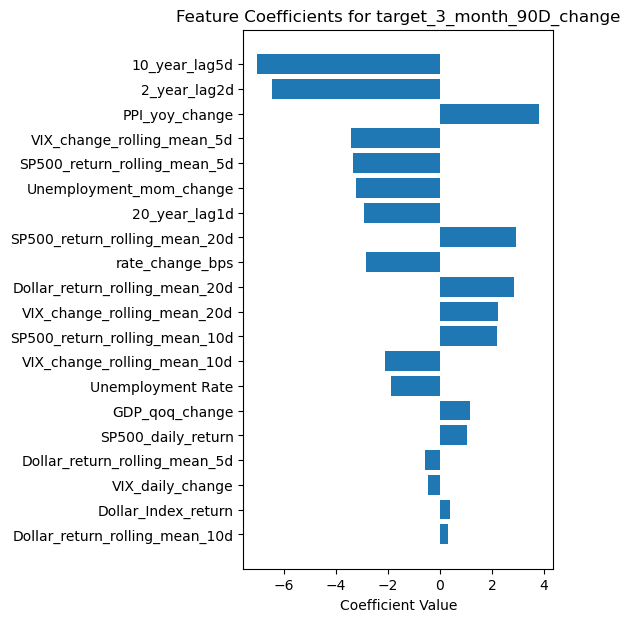

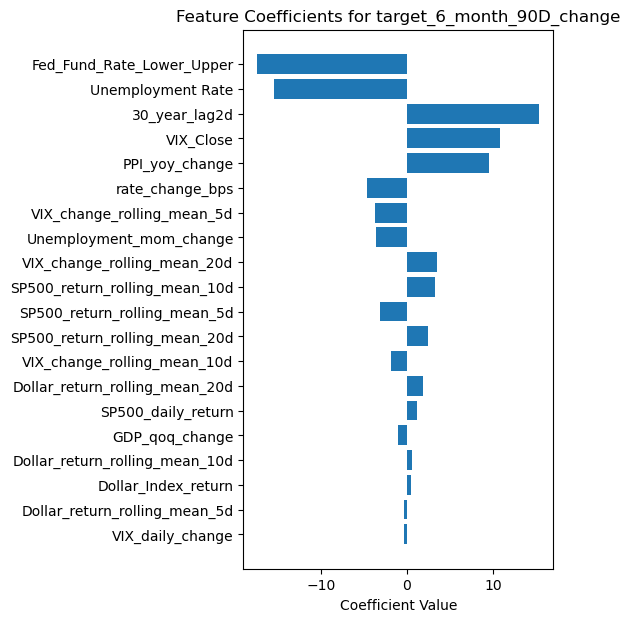

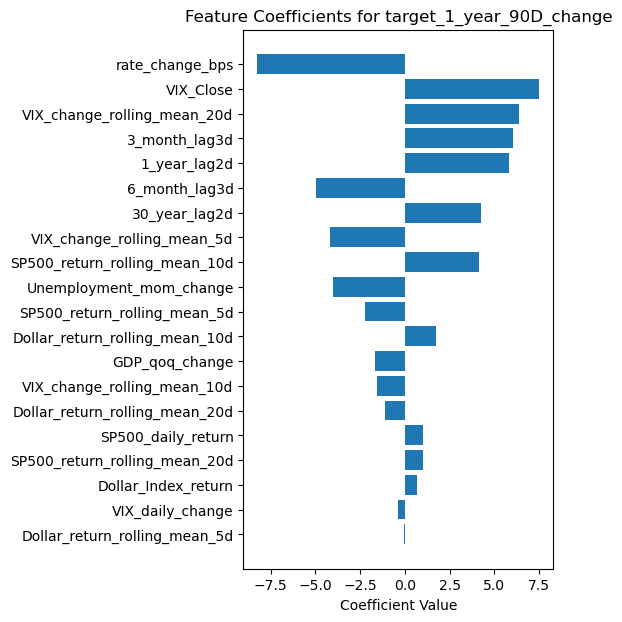

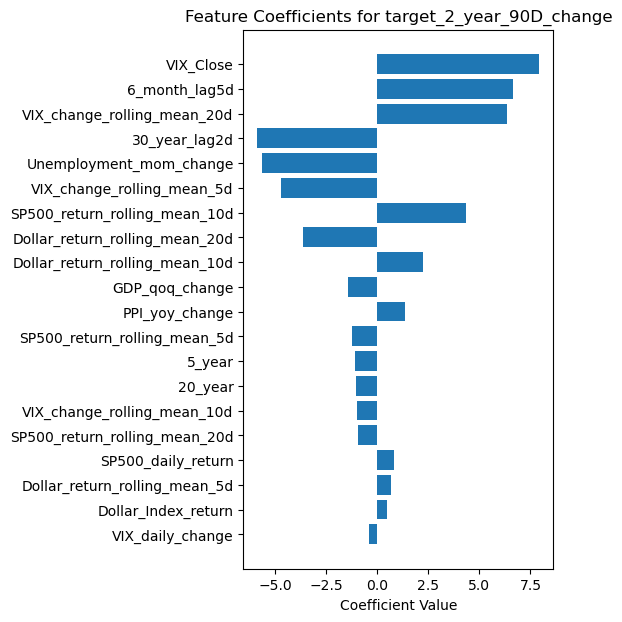

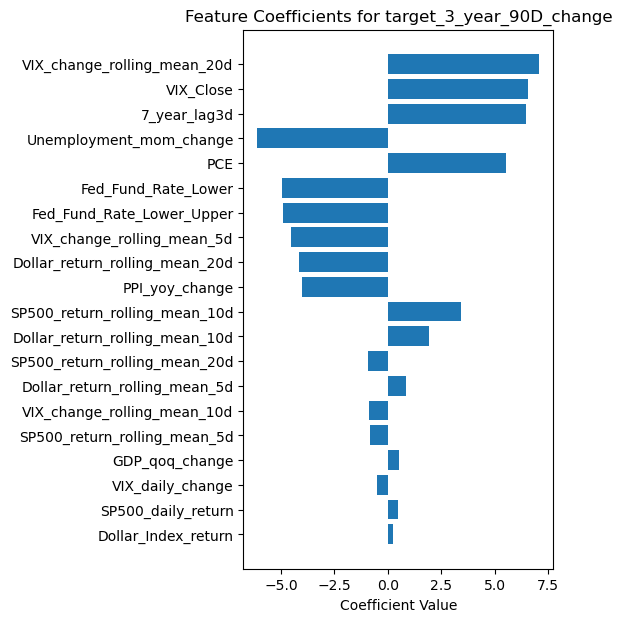

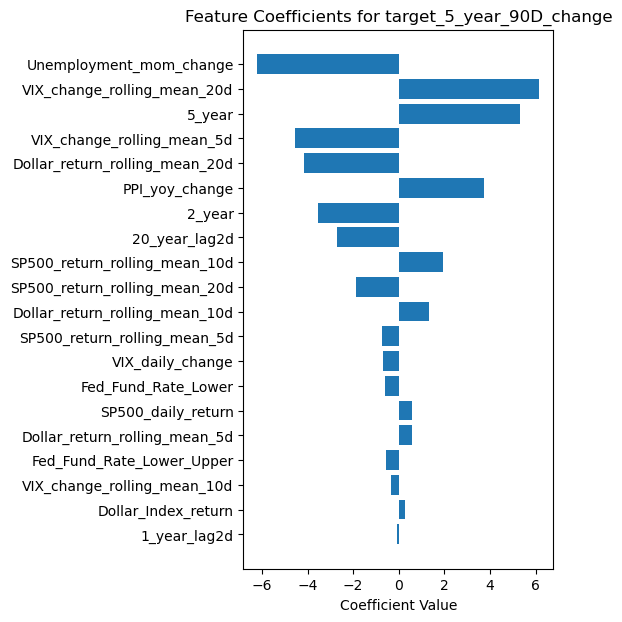

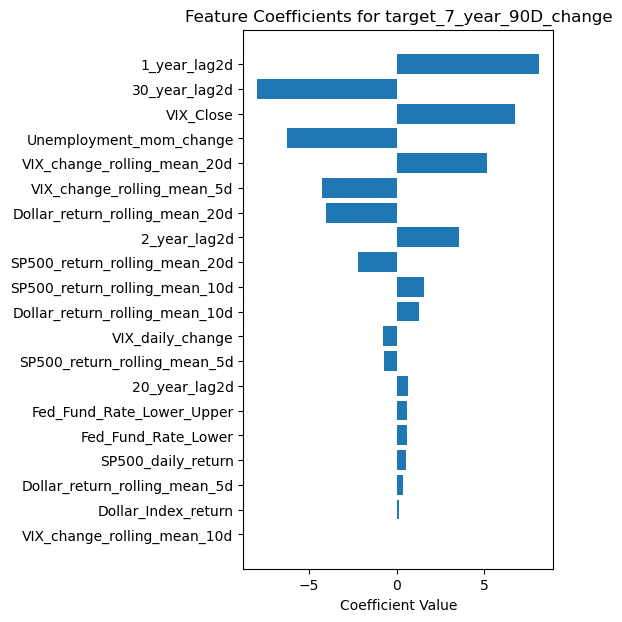

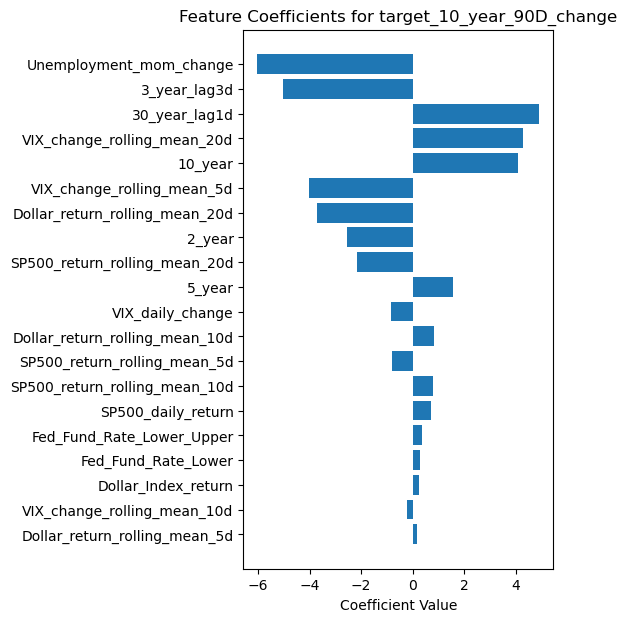

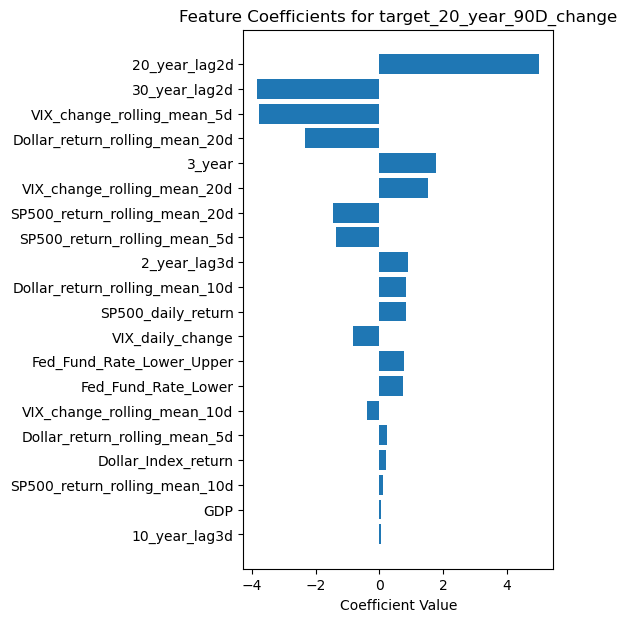

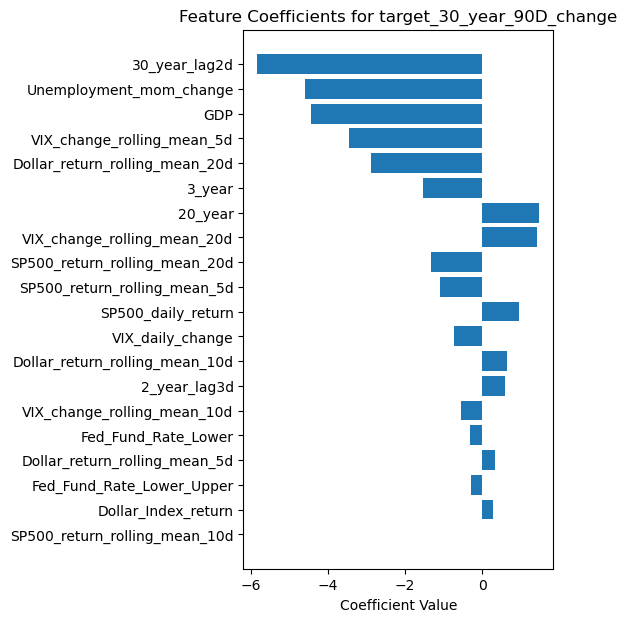

In [41]:
# Get target names from y_train columns
target_names = y_train.columns

# Check shape of coefficients
print("Coefficient matrix shape:", lr.coef_.shape)
# Shape should be (n_targets, n_features)

# Loop over each target and plot coefficients
for i, target_name in enumerate(target_names):
    plt.figure(figsize=(4, 7))
    # Extract coefficients for target i
    coef = lr.coef_[i]
    # Create DataFrame for visualization
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': coef
    })
    # Add absolute importance for sorting
    coef_df['abs_coeff'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values(by='abs_coeff', ascending=True)[:20]
    plt.barh(coef_df['feature'], coef_df['coefficient'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Coefficients for {target_name}')
    plt.show()

Less than 15 out of 83 features have significant coefficients per target, indicating many irrelevant features. Consider performing feature selection by keeping only these active features to improve model simplicity and prevent overfitting.

---

- Train Individual Models for Each Term Yield Change

In [42]:
for target in target_cols:
    print(f"\n--- Target: {target} ---")
    
    # Get the target values
    y_train_target = y_train[target]
    y_valid_target = y_valid[target]
    
    # Initialize and train the model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train_target)
    
    # Predictions
    y_train_pred = lr.predict(X_train_scaled)
    y_valid_pred = lr.predict(X_valid_scaled)
    
    # Calculate and print scores
    train_r2 = r2_score(y_train_target, y_train_pred)
    valid_r2 = r2_score(y_valid_target, y_valid_pred)
    print(f"Train R²: {train_r2:.4f}")
    print(f"Validation R²: {valid_r2:.4f}")


--- Target: target_3_month_90D_change ---
Train R²: 0.9558
Validation R²: -4.9304

--- Target: target_6_month_90D_change ---
Train R²: 0.9497
Validation R²: -3.1477

--- Target: target_1_year_90D_change ---
Train R²: 0.9357
Validation R²: -2.5025

--- Target: target_2_year_90D_change ---
Train R²: 0.9119
Validation R²: -4.6691

--- Target: target_3_year_90D_change ---
Train R²: 0.9028
Validation R²: -6.7039

--- Target: target_5_year_90D_change ---
Train R²: 0.8901
Validation R²: -8.3236

--- Target: target_7_year_90D_change ---
Train R²: 0.8882
Validation R²: -8.1596

--- Target: target_10_year_90D_change ---
Train R²: 0.8870
Validation R²: -9.2783

--- Target: target_20_year_90D_change ---
Train R²: 0.8910
Validation R²: -7.3202

--- Target: target_30_year_90D_change ---
Train R²: 0.8873
Validation R²: -7.2210


---

### 6.2 Random Forest Model <a class="anchor" id="6b"></a>

I will train Random Forest Model here to check if it performed poorly on the validation data, even though this is very likely, the performance and feature importance can still give us valuable insights. 

In [43]:
# Initialize the Random Forest regressor
rf = RandomForestRegressor(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Maximum depth of each tree
    min_samples_split=10,    # Min samples to split a node
    random_state=42,         # For reproducibility
    n_jobs=-1               # Use all available CPU cores
)

In [44]:
# Fit the model
rf.fit(X_train_scaled, y_train)

# Make predictions on validation data
y_pred_rf_train = rf.predict(X_train_scaled)
y_pred_rf_val = rf.predict(X_valid_scaled)

In [45]:
# Get the score for both train and validation set 
print("Train: Random Forest MSE:", mean_squared_error(y_train, y_pred_rf_train))
print("Train: R2 Score:", r2_score(y_train, y_pred_rf_train))

print("Validation: Random Forest MSE:", mean_squared_error(y_valid, y_pred_rf_val))
print("Validation: R2 Score:", r2_score(y_valid, y_pred_rf_val))

Train: Random Forest MSE: 39.52236796437829
Train: R2 Score: 0.9921216985892085
Validation: Random Forest MSE: 7610.51890505347
Validation: R2 Score: -1.7344200943006378


Again, overfitting is a critical issue in the Random Forest Model.

- Visualize feature importance

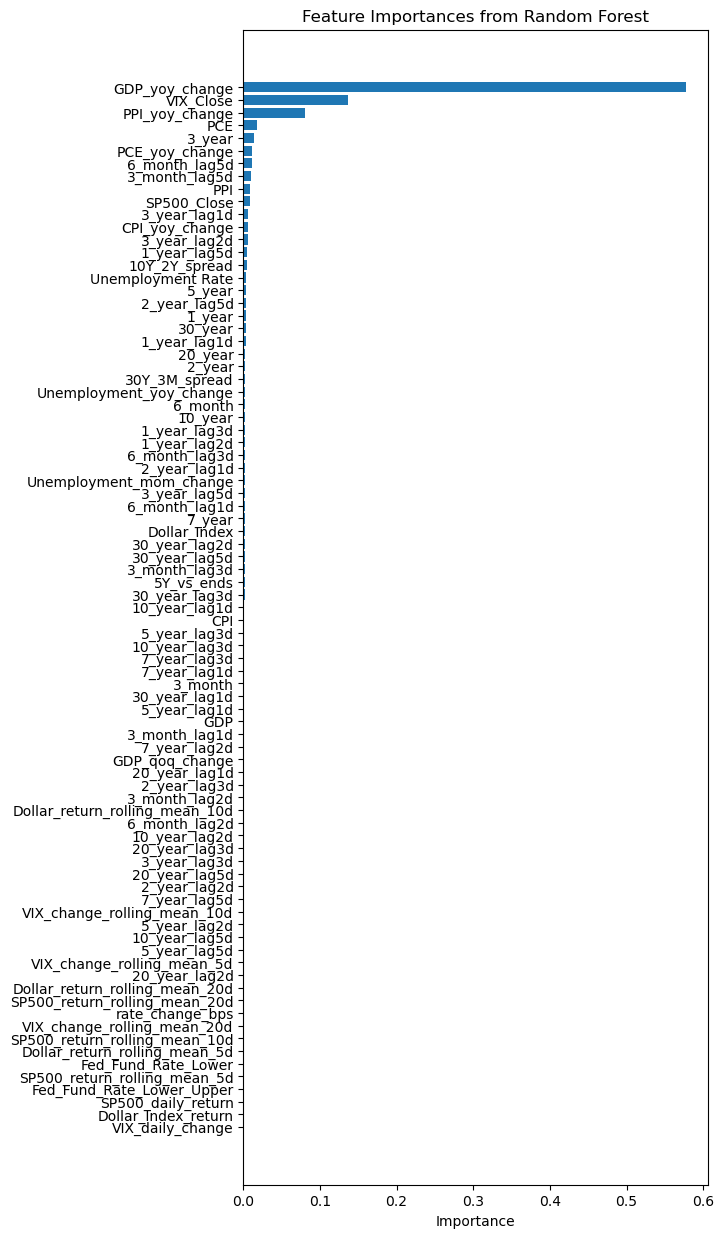

In [46]:
# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(6, 15))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

The feature importance analysis indicates a presence of many redundant features, which may contribute to overfitting. Interestingly, some key indicators such as GDP_yoy_change, PPI_yoy_change, and PCE were not deemed important in the linear regression model, suggesting that more flexible models might better capture their influence on yield curve movements.

---

### 6.3 XGBoost <a class="anchor" id="6c"></a>

In [47]:
# 1. Initialize the XGBoost regressor
xgb = xgb.XGBRegressor(
    n_estimators=100,       # number of trees
    max_depth=5,            # maximum depth of trees
    learning_rate=0.01,     # learning rate
    subsample=0.8,          # subsample ratio
    colsample_bytree=0.8,   # subsample ratio of columns
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'  # for regression
)


In [48]:
# 2. Fit the model
xgb.fit(X_train_scaled, y_train)

# Make predictions on train and validation data
y_pred_xgb_train = xgb.predict(X_train_scaled)
y_pred_xgb_val = xgb.predict(X_valid_scaled)

In [49]:
# Get the score for both train and validation set 
print("Train: XGBoost MSE:", mean_squared_error(y_train, y_pred_xgb_train))
print("Train: R2 Score:", r2_score(y_train, y_pred_xgb_train))

print("Validation: XGBoost MSE:", mean_squared_error(y_valid, y_pred_xgb_val))
print("Validation: R2 Score:", r2_score(y_valid, y_pred_xgb_val))

Train: XGBoost MSE: 975.9580901438055
Train: R2 Score: 0.8315451316527724
Validation: XGBoost MSE: 3203.2051633959577
Validation: R2 Score: -0.10632827534607792


Again, overfitting is a critical issue in the XGBoost

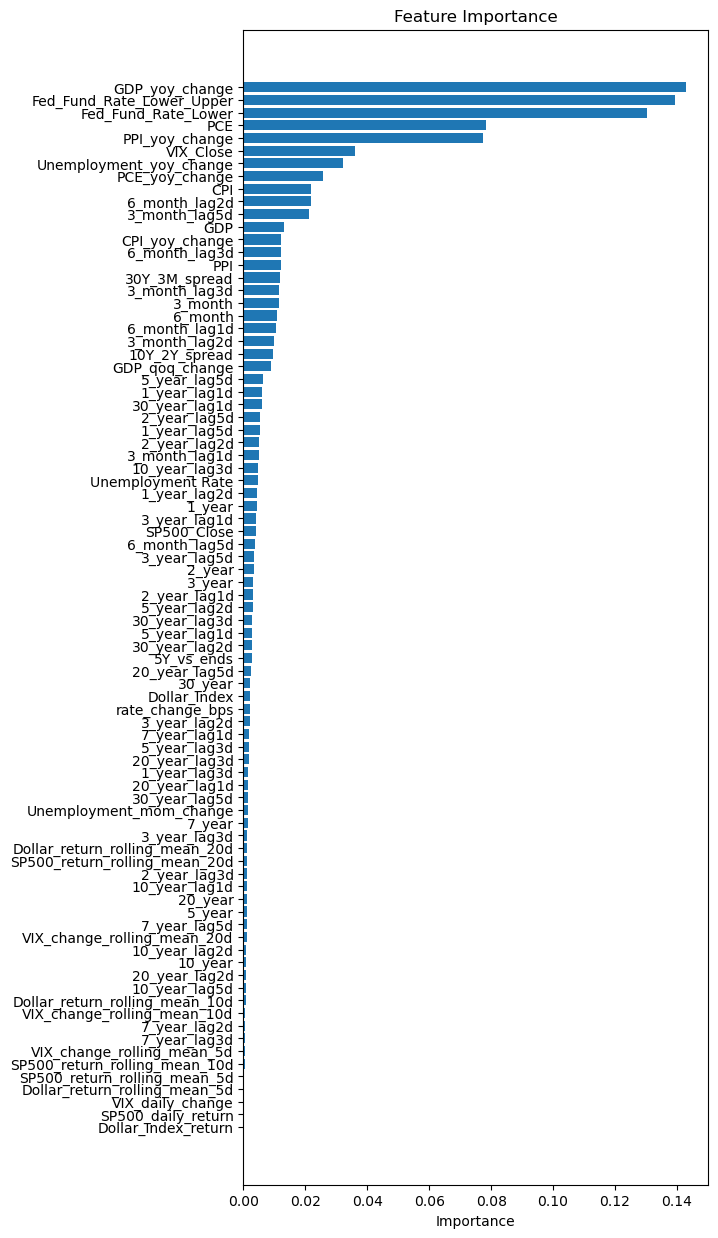

In [50]:
importances = xgb.feature_importances_

# Create a DataFrame with feature names
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(6,15))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

Just like random forest model, the feature importance analysis indicates a presence of many redundant features, which may contribute to overfitting.

---

## 7. Regime Splitting <a class="anchor" id="7"></a>

During our initial EDA, we observed that the treasury yield curve underwent substantial changes from January 2019 to October 2023. While yield curves in each regime share similar characteristics, key differences exist across regimes. In our previous models, we trained using data from January 2019 to January 2023 and validated on data after February 2023. However, since the Fed began tightening and the yield curve inverted deeply after 2023, the models likely failed to capture yield dynamics in this new regime, leading to good training performance but poor test results. 

Therefore, in this section, I will analyze the regime shifts across 2019–2025, segment the data accordingly, and train separate models for each regime to compare their performances.

---

### 7.1 Regime Review <a class="anchor" id="7a"></a>

In [51]:
# --- 1. Define Maturities (True Time Ratio) ---
# The dictionary uses actual time ratios for X-axis positioning
maturity_map = {
    '3_month': 3/12, '6_month': 6/12, 
    '1_year': 1, '2_year': 2, '3_year': 3, '5_year': 5, 
    '7_year': 7, '10_year': 10, '20_year': 20, '30_year': 30
}
maturity_labels = list(maturity_map.keys())


# --- 2. Create Custom Staggered Tick Labels ---
# This ensures short-term labels don't overlap on the true time-ratio scale.
tick_positions = list(maturity_map.values())
custom_tick_text = []

for label in maturity_labels:
    custom_tick_text.append(label) # Standard (lower) row


# --- 3. Reshape the Data for Plotly (Long Format) ---
# Prepare the data for Plotly's animation frame.

df_plot_working = yield_df.copy() 

# FIX 1: Format the index to YYYY-MM-DD string for a clean slider
df_plot_working.index = df_plot_working.index.strftime('%Y-%m-%d') 

# Rename columns (Maturity names to numerical time)
df_plot_working = df_plot_working.rename(columns=maturity_map)

# Melt the data from wide to long format
df_long = df_plot_working.reset_index().melt(
    id_vars='index',
    var_name='Maturity_Time', # Actual time ratio is the X data
    value_name='Yield'
).rename(columns={'index': 'Date'})


# --- 4. Create Interactive Plotly Figure ---

fig = px.line(
    df_long,
    x='Maturity_Time',
    y='Yield',
    animation_frame='Date', # Uses the clean date string
    line_group='Date', 
    markers=True,
    title='U.S. Treasury Yield Curve Evolution (2019-01 To 2025-10)'
)


# --- 5. Customizing the Plot ---

# FIX 2: Set the plot width (1000px) and bottom margin (180px)
fig.update_layout(
    width=1000,
    margin=dict(l=40, r=40, t=80, b=180), 
    title_x=0.5
)

# FIX 3: Configure the X-axis for staggered, angled labels (hiding 3_month)
fig.update_xaxes(
    tickvals=tick_positions,
    ticktext=custom_tick_text, 
    title_text=None, # Hide "Maturity" label
    tickangle=-45,
    automargin=False
)

# FIX 4: Set Y-axis range from 0 to 6.5
fig.update_yaxes(
    range=[0, 6.5],
    title_text='Yield (%)'
)

# Customizing trace appearance and hover template
fig.update_traces(
    line=dict(color='blue', width=3),
    hovertemplate="<b>Date: %{customdata[0]}</b><br>" + 
                  "Yield: %{y:.2f}%<extra></extra>",
    customdata=df_long[['Date']] 
)

# Set animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 50 
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 20

fig.show()

### Regime Summary (2019–2025)

| Regime Time Period               |  Characteristics                                              | Key Rationale & Dominant Curve Shape                                                 |
|---------------------------|----------------------------------------------------------|----------------------------------------------------------------------------------------|
| **Jan 2019 – Mar 2020**   | *Late Cycle Flattening & Pre-Pandemic Inversion*       | Late post-GFC expansion; brief yield curve inversions in 2019; sharp COVID-19 crash. |
| **Apr 2020 – Oct 2021**     | *Zero-Bound & Early Recovery Steepening*              | Fed cut rates to zero; massive QE; yields rose; resulting in a steep curve.            |
| **Nov 2021 – Oct 2022**     | *"Inflation Panic" & Aggressive Rate Hikes*             | Rapid Fed tightening; curve flattened and inverted in mid-2022.                    |
| **Nov 2022 – May 2024**     | *Deepest Inversion & Peak Fed Funds Rate*               | Max restriction; deep inversion; markets saw recession risk heightening.           |
| **Jun 2024 – Oct 2025**     | *Normalization/Steepening on Rate Cut Expectations*   | Inversion unwinds; market prices in rate cuts; curve normalizes and steepens.       |


---

### 7.2 Splitting Data into Regime-Specific Subsets <a class="anchor" id="7b"></a>

In [52]:
# Define Regimes
regimes = [
    ('2019-01-07', '2020-03-31'),  # Late Cycle Flattening
    ('2020-04-01', '2021-10-29'),  # Zero-Bound & Early Recovery Steepening
    ('2021-11-01', '2022-10-31'),  # Inflation Panic & Aggresive Rate Hikes
    ('2022-11-01', '2024-05-31'),  # Deep Inversion
    ('2024-06-03', '2025-10-22')   # Normalization & Steepening
]

In [53]:
# To store train/validation splits for each regime
regime_splits = []

for start_date, end_date in regimes:
    regime_df = agg_fe_df.loc[start_date:end_date].copy()

    # Determine cutoff index to leave 90 rows for future prediction
    n_rows = len(regime_df)
    cutoff_idx = n_rows - 90  # leave last 90 rows for future targets
    
    # Ensure there are enough rows
    if cutoff_idx <= 0:
        print(f"Not enough data in regime {start_date} to leave 90 rows for prediction.")
        continue

    # Split into training (up to cutoff), validation (after cutoff)
    train_part = regime_df.iloc[:cutoff_idx]
    valid_part = regime_df.iloc[cutoff_idx:]

    # Store the splits
    regime_splits.append((train_part, valid_part))
    
    print(f"Regime from {start_date} to {end_date}")
    print(f"  Training data: {train_part.shape}")
    print(f"  Validation data: {valid_part.shape}")

Regime from 2019-01-07 to 2020-03-31
  Training data: (202, 93)
  Validation data: (90, 93)
Regime from 2020-04-01 to 2021-10-29
  Training data: (308, 93)
  Validation data: (90, 93)
Regime from 2021-11-01 to 2022-10-31
  Training data: (160, 93)
  Validation data: (90, 93)
Regime from 2022-11-01 to 2024-05-31
  Training data: (306, 93)
  Validation data: (90, 93)
Regime from 2024-06-03 to 2025-10-22
  Training data: (167, 93)
  Validation data: (90, 93)


---


## 8. Train the Linear Regression on the five regimes <a class="anchor" id="8"></a>

In this section, I will train a separate linear regression model for each financial regime and each target term yield change. With 5 regimes and 10 term yield changes, this will result in a total of 50 models. Later, we will compare the performance of these models with our previous approach, which involved training a single linear regression model across all terms and validating it during different financial regimes.

---

### 8.1 Model Training <a class="anchor" id="8a"></a>

In [56]:
# Review target columns
target_cols

Index(['target_3_month_90D_change', 'target_6_month_90D_change',
       'target_1_year_90D_change', 'target_2_year_90D_change',
       'target_3_year_90D_change', 'target_5_year_90D_change',
       'target_7_year_90D_change', 'target_10_year_90D_change',
       'target_20_year_90D_change', 'target_30_year_90D_change'],
      dtype='object')

In [77]:
# Loop through five regimes
# Within each regime, train a model separately for each term yield
# Print the performance

# Initialize an empty list to store results
results_lr = []

for regime_num in range(5):
    # Get the train and validation data for each regime
    train_df, valid_df = regime_splits[regime_num]

    for target_col in target_cols:
        # Loop through each target, target_3_month_90D_change', 'target_6_month_90D_change'...
        # Define our train and target data
        X_train = train_df.drop(columns=target_cols)
        y_train = train_df[target_col]
        X_valid = valid_df.drop(columns=target_cols)
        y_valid = valid_df[target_col]

        # Feature Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        # Initialize and train the model
        lr = LinearRegression()
        lr.fit(X_train_scaled, y_train)

        # Make predictions
        y_train_pred = lr.predict(X_train_scaled)
        y_valid_pred = lr.predict(X_valid_scaled)

        # Calculate scores
        train_r2 = r2_score(y_train, y_train_pred).round(3)
        valid_r2 = r2_score(y_valid, y_valid_pred).round(3)

        # Store results in list
        results_lr.append({
            'regime': regime_num + 1,
            'target': target_col,
            'train_R2': train_r2,
            'valid_R2': valid_r2
        })

In [78]:
# Store the results in a DataFrame
results_lr_df = pd.DataFrame(results_lr)

# Create a column to store the score difference
results_lr_df['r2_difference'] = results_lr_df['train_R2'] - results_lr_df['valid_R2']

# Check results for each regime
for regime in range(1, 6):
    display(results_lr_df[results_lr_df['regime'] == regime])

regime                     target  train_R2  valid_R2  r2_difference
0       1  target_3_month_90D_change     0.950    -1.352          2.302
1       1  target_6_month_90D_change     0.949     0.117          0.832
2       1   target_1_year_90D_change     0.955     0.436          0.519
3       1   target_2_year_90D_change     0.964     0.141          0.823
4       1   target_3_year_90D_change     0.967     0.078          0.889
5       1   target_5_year_90D_change     0.965    -0.189          1.154
6       1   target_7_year_90D_change     0.963    -0.338          1.301
7       1  target_10_year_90D_change     0.958    -1.026          1.984
8       1  target_20_year_90D_change     0.953    -1.277          2.230
9       1  target_30_year_90D_change     0.946    -1.897          2.843

regime                     target  train_R2  valid_R2  r2_difference
10       2  target_3_month_90D_change     0.961    -1.931          2.892
11       2  target_6_month_90D_change     0.956    -2.127          3.083
12       2   target_1_year_90D_change     0.945    -2.758          3.703
13       2   target_2_year_90D_change     0.929    -4.547          5.476
14       2   target_3_year_90D_change     0.926    -5.895          6.821
15       2   target_5_year_90D_change     0.951    -8.479          9.430
16       2   target_7_year_90D_change     0.970    -6.084          7.054
17       2  target_10_year_90D_change     0.978    -3.008          3.986
18       2  target_20_year_90D_change     0.977    -1.029          2.006
19       2  target_30_year_90D_change     0.976    -1.362          2.338

regime                     target  train_R2  valid_R2  r2_difference
20       3  target_3_month_90D_change     0.997    -5.550          6.547
21       3  target_6_month_90D_change     0.994    -8.287          9.281
22       3   target_1_year_90D_change     0.937    -5.740          6.677
23       3   target_2_year_90D_change     0.972    -4.824          5.796
24       3   target_3_year_90D_change     0.972    -4.894          5.866
25       3   target_5_year_90D_change     0.971    -8.890          9.861
26       3   target_7_year_90D_change     0.968    -7.426          8.394
27       3  target_10_year_90D_change     0.969   -10.240         11.209
28       3  target_20_year_90D_change     0.968   -12.452         13.420
29       3  target_30_year_90D_change     0.964   -15.975         16.939

regime                     target  train_R2  valid_R2  r2_difference
30       4  target_3_month_90D_change     0.992    -0.482          1.474
31       4  target_6_month_90D_change     0.984    -0.696          1.680
32       4   target_1_year_90D_change     0.977     0.344          0.633
33       4   target_2_year_90D_change     0.969     0.453          0.516
34       4   target_3_year_90D_change     0.966     0.377          0.589
35       4   target_5_year_90D_change     0.962     0.347          0.615
36       4   target_7_year_90D_change     0.964     0.378          0.586
37       4  target_10_year_90D_change     0.965     0.404          0.561
38       4  target_20_year_90D_change     0.967     0.705          0.262
39       4  target_30_year_90D_change     0.964     0.689          0.275

regime                     target  train_R2  valid_R2  r2_difference
40       5  target_3_month_90D_change     0.998    -0.233          1.231
41       5  target_6_month_90D_change     0.998    -3.924          4.922
42       5   target_1_year_90D_change     0.992    -4.126          5.118
43       5   target_2_year_90D_change     0.988    -7.138          8.126
44       5   target_3_year_90D_change     0.988   -10.713         11.701
45       5   target_5_year_90D_change     0.987    -5.726          6.713
46       5   target_7_year_90D_change     0.984    -2.758          3.742
47       5  target_10_year_90D_change     0.982    -0.799          1.781
48       5  target_20_year_90D_change     0.972    -1.171          2.143
49       5  target_30_year_90D_change     0.970    -1.606          2.576

---

### 8.2 Model Performance Interpretation & Insights <a class="anchor" id="8b"></a>

Even when I break down the modeling into 50 separate models—training each one only during its respective regime and term—the models still struggle to capture the true relationships between predictors and targets. Here are some key insights:

1. Severe Overfitting
<br>This is the primary issue across the board. The training R² scores are exceptionally high, indicating the models fit the training data very well. However, the validation R² scores are overwhelmingly negative, demonstrating that the models are learning noise rather than meaningful signals. This leads to performance worse than a simple baseline average, highlighting severe overfitting.

2. Regime 4: The Only Success
<br>Regime 4 stands out as the only regime with consistently positive validation R² scores. Notably, it achieves a maximum R² of 0.705 on the 20-year target, indicating a stable and somewhat generalizable model structure or a simpler underlying dynamic during this period.


3. Term Structure Instability
<br>While Regime 4 shows its best performance on longer-term yields (notably 20-year), Regimes 2 and 3 show their worst failures on these same long terms (10-30 years). This pattern indicates that the factors influencing long-end yield changes are highly regime-dependent and likely non-linear, complicating modeling efforts in those periods.


---

### 8.3 LR with L1 regularization <a class="anchor" id="8c"></a>

Overfitting is a significant concern. To address this, I will apply Lasso regularization, which introduces an L1 penalty that encourages less important feature coefficients to shrink towards zero. This process can help improve model generalization by simplifying the model and reducing overfitting.

In [81]:
# Initialize an empty list to store results
results_lasso = []

for regime_num in range(5):
    # Get the train and validation data for each regime
    train_df, valid_df = regime_splits[regime_num]

    for target_col in target_cols:
        # Define your train and target data
        X_train = train_df.drop(columns=target_cols)
        y_train = train_df[target_col]
        X_valid = valid_df.drop(columns=target_cols)
        y_valid = valid_df[target_col]

        # Feature Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        # Initialize and train Lasso model with alpha (regularization strength)
        lasso = Lasso(alpha=0.01)  # Adjust alpha as needed
        lasso.fit(X_train_scaled, y_train)

        # Make predictions
        y_train_pred = lasso.predict(X_train_scaled)
        y_valid_pred = lasso.predict(X_valid_scaled)

        # Calculate R2 scores
        train_r2 = r2_score(y_train, y_train_pred).round(3)
        valid_r2 = r2_score(y_valid, y_valid_pred).round(3)

        # Store results
        results_lasso.append({
            'regime': regime_num + 1,
            'target': target_col,
            'train_R2': train_r2,
            'valid_R2': valid_r2
        })

c:\Users\yehua\anaconda3\envs\new_ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.040e+03, tolerance: 1.998e+01

c:\Users\yehua\anaconda3\envs\new_ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.842e+03, tolerance: 1.850e+01

c:\Users\yehua\anaconda3\envs\new_ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.968e+03, tolerance: 1.797e+01

c:\Users\yehua\anac

In [82]:
# Store the results in a DataFrame
results_lasso_df = pd.DataFrame(results_lasso)

# Create a column to store the score difference between train and validation
results_lasso_df['r2_difference'] = results_lasso_df['train_R2'] - results_lasso_df['valid_R2']

# Check results for each regime
for regime in range(1, 6):
    display(results_lasso_df[results_lasso_df['regime'] == regime])

regime                     target  train_R2  valid_R2  r2_difference
0       1  target_3_month_90D_change     0.926    -5.336          6.262
1       1  target_6_month_90D_change     0.924    -3.627          4.551
2       1   target_1_year_90D_change     0.933    -2.266          3.199
3       1   target_2_year_90D_change     0.952    -1.763          2.715
4       1   target_3_year_90D_change     0.956    -2.097          3.053
5       1   target_5_year_90D_change     0.954    -2.813          3.767
6       1   target_7_year_90D_change     0.951    -3.376          4.327
7       1  target_10_year_90D_change     0.945    -4.182          5.127
8       1  target_20_year_90D_change     0.939    -5.778          6.717
9       1  target_30_year_90D_change     0.930    -5.966          6.896

regime                     target  train_R2  valid_R2  r2_difference
10       2  target_3_month_90D_change     0.941    -0.716          1.657
11       2  target_6_month_90D_change     0.932    -0.933          1.865
12       2   target_1_year_90D_change     0.914    -1.522          2.436
13       2   target_2_year_90D_change     0.911    -2.715          3.626
14       2   target_3_year_90D_change     0.915    -3.153          4.068
15       2   target_5_year_90D_change     0.940    -4.607          5.547
16       2   target_7_year_90D_change     0.961    -2.217          3.178
17       2  target_10_year_90D_change     0.969    -1.651          2.620
18       2  target_20_year_90D_change     0.968    -1.095          2.063
19       2  target_30_year_90D_change     0.969    -0.912          1.881

regime                     target  train_R2  valid_R2  r2_difference
20       3  target_3_month_90D_change     0.993     0.164          0.829
21       3  target_6_month_90D_change     0.988    -0.094          1.082
22       3   target_1_year_90D_change     0.905    -3.612          4.517
23       3   target_2_year_90D_change     0.960    -4.313          5.273
24       3   target_3_year_90D_change     0.961    -6.844          7.805
25       3   target_5_year_90D_change     0.961   -17.562         18.523
26       3   target_7_year_90D_change     0.955   -23.623         24.578
27       3  target_10_year_90D_change     0.955   -30.908         31.863
28       3  target_20_year_90D_change     0.951   -30.934         31.885
29       3  target_30_year_90D_change     0.945   -36.251         37.196

regime                     target  train_R2  valid_R2  r2_difference
30       4  target_3_month_90D_change     0.991    -0.192          1.183
31       4  target_6_month_90D_change     0.982     0.246          0.736
32       4   target_1_year_90D_change     0.973     0.732          0.241
33       4   target_2_year_90D_change     0.963     0.809          0.154
34       4   target_3_year_90D_change     0.958     0.848          0.110
35       4   target_5_year_90D_change     0.955     0.860          0.095
36       4   target_7_year_90D_change     0.957     0.860          0.097
37       4  target_10_year_90D_change     0.959     0.810          0.149
38       4  target_20_year_90D_change     0.962     0.568          0.394
39       4  target_30_year_90D_change     0.959     0.748          0.211

regime                     target  train_R2  valid_R2  r2_difference
40       5  target_3_month_90D_change     0.996    -1.798          2.794
41       5  target_6_month_90D_change     0.997    -3.976          4.973
42       5   target_1_year_90D_change     0.989    -4.693          5.682
43       5   target_2_year_90D_change     0.984    -7.114          8.098
44       5   target_3_year_90D_change     0.985    -8.573          9.558
45       5   target_5_year_90D_change     0.983    -5.752          6.735
46       5   target_7_year_90D_change     0.980    -2.884          3.864
47       5  target_10_year_90D_change     0.977    -0.694          1.671
48       5  target_20_year_90D_change     0.964     0.421          0.543
49       5  target_30_year_90D_change     0.962     0.230          0.732

---

### 8.4 Model Performance Interpretation & Insights <a class="anchor" id="8d"></a>

- **Lasso improves out-of-sample performance by reducing overfitting, especially during turbulent regimes.**  
  It constrains model complexity, preventing the capture of noise and leading to more robust, generalizable predictions in volatile periods.

- **Lasso yields simpler, more interpretable models by focusing on fewer, more important features.**  
  It shrinks less relevant coefficients to zero, highlighting key predictors and making insights clearer.

- **Longer-term yield predictions benefit most from regularization because signals are weaker and noisier.**  
  By filtering out noise, Lasso provides more stable and reliable forecasts for extended horizons where signals are less clear.

- **Despite these improvements, the models still perform poorly in capturing the true underlying relationships**—they often fail to model the complex, regime-dependent dynamics that drive yield changes, especially during periods of structural shifts or regime changes.

---

## 9. Train the Random Forest on the five regimes <a class="anchor" id="9"></a>

In this section, I will train a separate random forest model for each financial regime and each target term yield change. With 5 regimes and 10 term yield changes, this will result in a total of 50 models. Later, we will compare the performance of these models with our previous approach, which involved training a single random forest model across all terms and validating it during different financial regimes.

### 9.1 Model Training <a class="anchor" id="9a"></a>

In [79]:
# Initialize an empty list to store results
results_rf = []

# Loop through each regime
for regime_num in range(5):
    # Get the train and validation data for each regime
    train_df, valid_df = regime_splits[regime_num]

    for target_col in target_cols:
        # Define features and target for each target term
        X_train = train_df.drop(columns=target_cols)
        y_train = train_df[target_col]
        X_valid = valid_df.drop(columns=target_cols)
        y_valid = valid_df[target_col]

        # Feature Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        # Initialize and train the Random Forest model
        rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        rf.fit(X_train_scaled, y_train)

        # Make predictions
        y_train_pred = rf.predict(X_train_scaled)
        y_valid_pred = rf.predict(X_valid_scaled)

        # Calculate R² scores
        train_r2 = r2_score(y_train, y_train_pred).round(3)
        valid_r2 = r2_score(y_valid, y_valid_pred).round(3)

        # Store results
        results_rf.append({
            'regime': regime_num + 1,
            'target': target_col,
            'train_R2': train_r2,
            'valid_R2': valid_r2  
        })

In [80]:
# Store the results in a DataFrame
results_rf_df = pd.DataFrame(results_rf)

# Create a column to store the score difference
results_rf_df['r2_difference'] = results_rf_df['train_R2'] - results_rf_df['valid_R2']

# Check results for each regime
for regime in range(1, 6):
    display(results_rf_df[results_rf_df['regime'] == regime])

regime                     target  train_R2  valid_R2  r2_difference
0       1  target_3_month_90D_change     0.996    -0.252          1.248
1       1  target_6_month_90D_change     0.995    -0.256          1.251
2       1   target_1_year_90D_change     0.996    -0.199          1.195
3       1   target_2_year_90D_change     0.995    -0.483          1.478
4       1   target_3_year_90D_change     0.996    -0.389          1.385
5       1   target_5_year_90D_change     0.996     0.000          0.996
6       1   target_7_year_90D_change     0.994     0.073          0.921
7       1  target_10_year_90D_change     0.995     0.376          0.619
8       1  target_20_year_90D_change     0.994     0.563          0.431
9       1  target_30_year_90D_change     0.993     0.355          0.638

regime                     target  train_R2  valid_R2  r2_difference
10       2  target_3_month_90D_change     0.986    -0.583          1.569
11       2  target_6_month_90D_change     0.985    -1.273          2.258
12       2   target_1_year_90D_change     0.984    -1.545          2.529
13       2   target_2_year_90D_change     0.992    -1.814          2.806
14       2   target_3_year_90D_change     0.993    -1.863          2.856
15       2   target_5_year_90D_change     0.993    -2.061          3.054
16       2   target_7_year_90D_change     0.995    -4.017          5.012
17       2  target_10_year_90D_change     0.996    -2.185          3.181
18       2  target_20_year_90D_change     0.997    -2.126          3.123
19       2  target_30_year_90D_change     0.996    -0.868          1.864

regime                     target  train_R2  valid_R2  r2_difference
20       3  target_3_month_90D_change     0.998    -3.825          4.823
21       3  target_6_month_90D_change     0.997    -4.127          5.124
22       3   target_1_year_90D_change     0.973    -2.051          3.024
23       3   target_2_year_90D_change     0.986    -0.878          1.864
24       3   target_3_year_90D_change     0.988    -0.876          1.864
25       3   target_5_year_90D_change     0.987    -0.882          1.869
26       3   target_7_year_90D_change     0.990    -0.608          1.598
27       3  target_10_year_90D_change     0.992    -0.462          1.454
28       3  target_20_year_90D_change     0.989    -1.738          2.727
29       3  target_30_year_90D_change     0.985    -1.285          2.270

regime                     target  train_R2  valid_R2  r2_difference
30       4  target_3_month_90D_change     0.997    -0.466          1.463
31       4  target_6_month_90D_change     0.995    -0.529          1.524
32       4   target_1_year_90D_change     0.994    -0.740          1.734
33       4   target_2_year_90D_change     0.995     0.013          0.982
34       4   target_3_year_90D_change     0.994    -0.089          1.083
35       4   target_5_year_90D_change     0.995    -0.208          1.203
36       4   target_7_year_90D_change     0.995    -0.455          1.450
37       4  target_10_year_90D_change     0.996    -0.103          1.099
38       4  target_20_year_90D_change     0.997     0.351          0.646
39       4  target_30_year_90D_change     0.996     0.059          0.937

regime                     target  train_R2  valid_R2  r2_difference
40       5  target_3_month_90D_change     0.999    -0.464          1.463
41       5  target_6_month_90D_change     0.999    -0.922          1.921
42       5   target_1_year_90D_change     0.996    -0.966          1.962
43       5   target_2_year_90D_change     0.996    -1.338          2.334
44       5   target_3_year_90D_change     0.995    -0.475          1.470
45       5   target_5_year_90D_change     0.994    -0.888          1.882
46       5   target_7_year_90D_change     0.994    -0.687          1.681
47       5  target_10_year_90D_change     0.994    -0.401          1.395
48       5  target_20_year_90D_change     0.991    -0.151          1.142
49       5  target_30_year_90D_change     0.992    -0.103          1.095

---

### 9.2 Model Performance Interpretation & Insights <a class="anchor" id="9b"></a>

1. **Overfitting**  
   While the models achieve very high training R² values , their validation R² scores are frequently highly negative, indicating they are heavily overfitting the training data. This disparity suggests the models are capturing noise rather than the true underlying patterns, leading to poor predictive performance on unseen data.

2. **Weaker Performance**  
   Although both linear regression and random forest struggle to accurately predict future yield changes, the random forest tends to perform worse overall. Notably, during Regime 4—where linear regression showed relatively better results—random forest's predictions were less accurate, indicating it may be less effective in capturing the underlying dynamics during more stable periods.

3. **Challenges with Long-Term Predictions**  
   The models tend to perform poorly on longer horizons (10–30 years) in regimes characterized by volatility or structural breaks. The validation R² often plummets, sometimes below -20, highlighting that long-term yield movements are highly regime-dependent and involve complex, non-linear influences that are difficult for tree-based models to capture reliably.

4. **Modeling Underlying Relationships Remains Difficult**  
   Despite the flexibility of Random Forests, they struggle to uncover the true drivers behind yield changes, especially during turbulent periods. The persistent poor validation performance indicates that external factors, regime shifts, or non-linear dynamics are not sufficiently modeled, emphasizing the need for models capable of adapting to non-stationarity and structural breaks.

---

### 9.3 Retrain Random Forest with Feature Selection <a class="anchor" id="9c"></a>

In this section, I will retrain the 50 models. For each model, after training, I will perform feature selection by selecting the top 10 most important features. I will then retrain the random forest model using only these selected features and evaluate whether this approach helps mitigate overfitting and improves model performance.

In [84]:
# Initialize list to store results
results_rf = []

for regime_num in range(5):
    train_df, valid_df = regime_splits[regime_num]
    
    for target_col in target_cols:
        # Define features and targets
        X_train = train_df.drop(columns=target_cols)
        y_train = train_df[target_col]
        X_valid = valid_df.drop(columns=target_cols)
        y_valid = valid_df[target_col]

        # Feature Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        # Fit Random Forest
        rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        rf.fit(X_train_scaled, y_train)
        
        # Get feature importances
        importances = rf.feature_importances_
        feature_names = X_train.columns

        # Create a DataFrame for importance scores
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })

        # Select top N features (e.g., top 10)
        top_features = importance_df.sort_values(by='importance', ascending=False).head(10)['feature']

        # Optional: retrain model on selected features
        X_train_selected = X_train[top_features]
        X_valid_selected = X_valid[top_features]
        
        # Re-scale the selected features
        scaler2 = StandardScaler()
        X_train_sel_scaled = scaler2.fit_transform(X_train_selected)
        X_valid_sel_scaled = scaler2.transform(X_valid_selected)

        # Retrain with selected features
        rf_selected = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        rf_selected.fit(X_train_sel_scaled, y_train)

        # Make predictions
        y_train_pred = rf_selected.predict(X_train_sel_scaled)
        y_valid_pred = rf_selected.predict(X_valid_sel_scaled)

        # Calculate R2 scores
        train_r2 = r2_score(y_train, y_train_pred).round(3)
        valid_r2 = r2_score(y_valid, y_valid_pred).round(3)

        # Store results
        results_rf.append({
            'regime': regime_num + 1,
            'target': target_col,
            'train_R2': train_r2,
            'valid_R2': valid_r2,
            'n_features': len(top_features)
        })

# Convert results to DataFrame for analysis
results_rf_df = pd.DataFrame(results_rf)

In [85]:
# Create a column to store the score difference
results_rf_df['r2_difference'] = results_rf_df['train_R2'] - results_rf_df['valid_R2']

# Check results for each regime
for regime in range(1, 6):
    display(results_rf_df[results_rf_df['regime'] == regime])

regime                     target  train_R2  valid_R2  n_features  \
0       1  target_3_month_90D_change     0.996    -0.387          10   
1       1  target_6_month_90D_change     0.994    -0.473          10   
2       1   target_1_year_90D_change     0.996    -0.293          10   
3       1   target_2_year_90D_change     0.996    -0.469          10   
4       1   target_3_year_90D_change     0.995    -0.385          10   
5       1   target_5_year_90D_change     0.995     0.094          10   
6       1   target_7_year_90D_change     0.993    -0.067          10   
7       1  target_10_year_90D_change     0.994     0.400          10   
8       1  target_20_year_90D_change     0.993     0.474          10   
9       1  target_30_year_90D_change     0.992     0.361          10   

   r2_difference  
0          1.383  
1          1.467  
2          1.289  
3          1.465  
4          1.380  
5          0.901  
6          1.060  
7          0.594  
8          0.519  
9          0.631

regime                     target  train_R2  valid_R2  n_features  \
10       2  target_3_month_90D_change     0.985    -0.584          10   
11       2  target_6_month_90D_change     0.984    -1.264          10   
12       2   target_1_year_90D_change     0.983    -1.467          10   
13       2   target_2_year_90D_change     0.991    -1.827          10   
14       2   target_3_year_90D_change     0.991    -1.532          10   
15       2   target_5_year_90D_change     0.992    -2.599          10   
16       2   target_7_year_90D_change     0.994    -3.808          10   
17       2  target_10_year_90D_change     0.996    -2.190          10   
18       2  target_20_year_90D_change     0.995    -2.518          10   
19       2  target_30_year_90D_change     0.994    -1.184          10   

    r2_difference  
10          1.569  
11          2.248  
12          2.450  
13          2.818  
14          2.523  
15          3.591  
16          4.802  
17          3.186  
18          3.513  
19          2.178

regime                     target  train_R2  valid_R2  n_features  \
20       3  target_3_month_90D_change     0.998    -3.096          10   
21       3  target_6_month_90D_change     0.994    -2.929          10   
22       3   target_1_year_90D_change     0.976    -2.249          10   
23       3   target_2_year_90D_change     0.985    -0.837          10   
24       3   target_3_year_90D_change     0.987    -0.738          10   
25       3   target_5_year_90D_change     0.985    -0.693          10   
26       3   target_7_year_90D_change     0.989    -0.743          10   
27       3  target_10_year_90D_change     0.991    -0.674          10   
28       3  target_20_year_90D_change     0.990    -1.337          10   
29       3  target_30_year_90D_change     0.988    -1.419          10   

    r2_difference  
20          4.094  
21          3.923  
22          3.225  
23          1.822  
24          1.725  
25          1.678  
26          1.732  
27          1.665  
28          2.327  
29          2.407

regime                     target  train_R2  valid_R2  n_features  \
30       4  target_3_month_90D_change     0.997    -0.531          10   
31       4  target_6_month_90D_change     0.995    -0.704          10   
32       4   target_1_year_90D_change     0.994    -1.110          10   
33       4   target_2_year_90D_change     0.995    -0.102          10   
34       4   target_3_year_90D_change     0.992    -0.352          10   
35       4   target_5_year_90D_change     0.992    -0.185          10   
36       4   target_7_year_90D_change     0.994    -0.399          10   
37       4  target_10_year_90D_change     0.995    -0.050          10   
38       4  target_20_year_90D_change     0.996     0.606          10   
39       4  target_30_year_90D_change     0.995     0.478          10   

    r2_difference  
30          1.528  
31          1.699  
32          2.104  
33          1.097  
34          1.344  
35          1.177  
36          1.393  
37          1.045  
38          0.390  
39          0.517

regime                     target  train_R2  valid_R2  n_features  \
40       5  target_3_month_90D_change     0.999    -0.219          10   
41       5  target_6_month_90D_change     0.999    -1.139          10   
42       5   target_1_year_90D_change     0.994    -1.277          10   
43       5   target_2_year_90D_change     0.993    -1.950          10   
44       5   target_3_year_90D_change     0.992    -0.719          10   
45       5   target_5_year_90D_change     0.993     0.108          10   
46       5   target_7_year_90D_change     0.992    -0.052          10   
47       5  target_10_year_90D_change     0.991     0.150          10   
48       5  target_20_year_90D_change     0.981    -0.111          10   
49       5  target_30_year_90D_change     0.988    -0.055          10   

    r2_difference  
40          1.218  
41          2.138  
42          2.271  
43          2.943  
44          1.711  
45          0.885  
46          1.044  
47          0.841  
48          1.092  
49          1.043

---

### 9.4 Model Performance Interpretation & Insights <a class="anchor" id="9d"></a>

- **Overfitting Persists:** Despite selecting the top 10 features, training R² remains very high, but validation R² is largely negative, indicating poor generalization.
- **Limited Validation Gains:** The large gap between train and validation R² shows that feature selection alone doesn't fully mitigate overfitting.
- **Better Performance in Stable Regimes:** Regimes 4 and 5 exhibit relatively higher validation R², especially for long-term targets, but overall accuracy remains limited.
- **Challenges in Long-Term Prediction:** Predicting 15-30 year yields remains difficult, particularly during volatile or regime-shifted periods.
- **Need for Advanced Models:** Focusing on important features isn't enough—nonlinearities and regime dependence likely drive yield changes, requiring more sophisticated approaches.

---

## 10. Summary and Next Steps <a class="anchor" id="10"></a>

### Summary and Key Takeaways

Despite incorporating seemingly relevant macroeconomic and market data, and dividing the yield curve into five regimes with distinct behaviors, machine learning models consistently struggle to predict future yield movements over a four-month horizon (90 trading days).

**Key Observations:**

- **Limited Short-Term Predictive Power:**  
  The models do not perform well in forecasting short-term yield changes. Likely because short-term fluctuations are heavily influenced by liquidity, market microstructure, and liquidity shocks, which are not captured in the current dataset.

- **Better Performance in Stable Regimes:**  
  During periods of low volatility, models can leverage macroeconomic indicators to predict longer-term yield changes more effectively. However, this improvement is limited to tranquil periods.

- **Fundamental Limitations:**  
  Even with extensive data and regime segmentation, models fail to fully capture the non-linear, regime-dependent, and liquidity-driven dynamics that dominate short-term yield fluctuations.

**Possible Reasons:**

- Short-term yield movements are driven by liquidity conditions, market microstructure, or macro shocks not reflected in macroeconomic data.
- The dataset lacks high-frequency, sentiment, or liquidity metrics crucial for short-term forecasting.
- The models may not sufficiently capture non-linear relationships or regime shifts, necessitating models that explicitly incorporate such features.

---

### Next Steps

- **Incorporate Liquidity and Microstructure Data:**  
  Gather high-frequency measures like bid-ask spreads, trading volumes, and investor sentiment indicators to better model liquidity-driven short-term changes.

- **Develop Regime-Aware and Non-Linear Models:**  
  Use models capable of detecting regime switches or non-linear patterns, such as Markov-switching models or deep learning approaches with regime indicators.

- **Consider Alternative Modeling Approaches:**  
  For predicting yield changes in the near future, relying on models like the **Dynamic Nelson-Siegel** may still be more effective. This model captures the underlying dynamics of the entire yield curve and tends to make more reliable predictions for future yield curve movements.
  
---